# Red Neuronal - Optimizacion II
*Prof. Cristhian Zambrano*

**Estudiantes:**  \\
Camilo Oberndorfer, \\
Maria Alejandra Moncada, \\
Miguel Valencia, \\
Pedro Botero



In [ ]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

# Neural network

## Neuron Layer

In [ ]:
# Creando capas
class Layer_Dense:
  
  # inicializando capas
  def __init__(self, n_inputs, n_neurons):

    # establecemos pesos y sesgos iniciales aleatorios
    self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
    self.biases = 0.01 * np.random.randn(1, n_neurons)
    
  # Paso hacia adelante
  def forward(self, inputs):

    # Guardamos los inputs para backward mas tarde
    self.inputs = inputs
    # Calculamos los outputs iniciales necesarios para cualquier funcion de activacion
    self.output = np.dot(inputs, self.weights) + self.biases

  # Paso hacia atras
  def backward(self, dvalues):
    # Hallamos el gradiente de pesos y sesgos
    self.dweights = np.dot(self.inputs.T, dvalues)
    self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

    # Hallamos el gradiente de los vaores de entrada
    self.dinputs = np.dot(dvalues, self.weights.T)


## Activation Functions

In [ ]:
# Linear
class Activation_Linear:
  # Paso hacia adelante
  def forward(self, inputs):

    # Remember input values
    self.inputs = inputs
    
    # Aplicamos ReLU a los datos salientes de la operación inicial
    self.output = inputs.copy()

  # Paso hacia atras
  def backward(self, dvalues):

    # No cabia los outputs entonces
    self.dinputs = dvalues.copy()

In [ ]:
# Step
class Activation_Step:

  # Paso hacia adelante
  def forward(self, inputs):

    # Guardamos los datos de entrada
    self.inputs = inputs
    self.output = np.copy(self.inputs)
    self.output[self.inputs <= 0] = 0
    self.output[self.inputs >= 0] = 1

  # Paso hacia atras
  def backward(self, dvalues):

    # Guardamos una copia de las derivadas
    self.dinputs = dvalues.copy()

    # Establece gradiante 0
    self.dinputs[True] = 0

In [ ]:
# ReLU
class Activation_ReLU:
  # Paso hacia adelante
  def forward(self, inputs):
    # Guardamos los datos de entrada
    self.inputs = inputs
    # Aplicamos ReLU a los datos salientes de la operación inicial
    self.output = np.maximum(0, inputs)

  # Paso hacia atras
  def backward(self, dvalues):
    
    # Guardamos una copia de las derivadas
    self.dinputs = dvalues.copy()

    # Establece gradiante 0 si los inputs son negativos
    self.dinputs[self.inputs <= 0] = 0

In [ ]:
# Softmax activation
class Activation_Softmax:

  # Forward pass
  def forward(self, inputs):

    # Remember input values
    self.inputs = inputs

    # Get unnormalized probabilities
    exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                        keepdims=True))
    
    # Normalize them for each sample
    probabilities = exp_values / np.sum(exp_values, axis=1,
                                        keepdims=True)
    self.output = probabilities

  # Backward pass
  def backward(self, dvalues):
    # Create uninitialized array
    self.dinputs = np.empty_like(dvalues)
    # Enumerate outputs and gradients
    for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
      # Flatten output array
      single_output = single_output.reshape(-1, 1)
      # Calculate Jacobian matrix of the output and
      jacobian_matrix = np.diagflat(single_output) - \
                        np.dot(single_output, single_output.T)

      # Calculate sample-wise gradient
      # and add it to the array of sample gradients
      self.dinputs[index] = np.dot(jacobian_matrix,
                                  single_dvalues)

## Optimizers

In [ ]:
# Random optimizer
class Optimizer_Random:
  
  # Initialize optimizer - set settings,
  # learning rate of 1. is default for this optimizer
  def __init__(self):
    self.iterations = 0
  
  # Update parameters
  def update_params(self, layer):

    # Update weights and biases using either
    # vanilla or momentum updates
    layer.weights += 0.1*np.random.randn(layer.weights[0].size)
    layer.biases += 0.1*np.random.randn(layer.weights[0].size)
      
  # Call once after any parameter updates
  def post_update_params(self):
    self.iterations += 1

In [ ]:
# SGD optimizer
class Optimizer_SGD:
  
  # Initialize optimizer - set settings,
  # learning rate of 1. is default for this optimizer
  def __init__(self, learning_rate=1., decay=0., momentum=0.):

    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations = 0
    self.momentum = momentum

  # Call once before any parameter updates
  def pre_update_params(self):

    if self.decay:
      self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

  # Update parameters
  def update_params(self, layer):

    # If we use momentum
    if self.momentum:

      # If layer does not contain momentum arrays, create them
      # filled with zeros
      if not hasattr(layer, 'weight_momentums'):
        layer.weight_momentums = np.zeros_like(layer.weights)
        
        # If there is no momentum array for weights
        # The array doesn't exist for biases yet either.
        layer.bias_momentums = np.zeros_like(layer.biases)

        # Build weight updates with momentum - take previous
        # updates multiplied by retain factor and update with
        # current gradients
        weight_updates = \
            self.momentum * layer.weight_momentums - \
            self.current_learning_rate * layer.dweights

        layer.weight_momentums = weight_updates
        # Build bias updates
        bias_updates = \
            self.momentum * layer.bias_momentums - \
            self.current_learning_rate * layer.dbiases

        layer.bias_momentums = bias_updates

    # Vanilla SGD updates (as before momentum update)
    else:
      weight_updates = -self.current_learning_rate * \
                      layer.dweights
      bias_updates = -self.current_learning_rate * \
                      layer.dbiases

    # Update weights and biases using either
    # vanilla or momentum updates
    layer.weights += weight_updates
    layer.biases += bias_updates

  # Call once after any parameter updates
  def post_update_params(self):
    self.iterations += 1

In [ ]:
# Adagrad optimizer
class Optimizer_Adagrad:
  # Initialize optimizer - set settings
  def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations = 0
    self.epsilon = epsilon

  # Call once before any parameter updates
  def pre_update_params(self):
    if self.decay:
      self.current_learning_rate = self.learning_rate * \
            (1. / (1. + self.decay * self.iterations))

  # Update parameters
  def update_params(self, layer):
    
    # If layer does not contain cache arrays,
    # create them filled with zeros
    if not hasattr(layer, 'weight_cache'):
      layer.weight_cache = np.zeros_like(layer.weights)
      layer.bias_cache = np.zeros_like(layer.biases)

    # Update cache with squared current gradients
    layer.weight_cache += layer.dweights**2
    layer.bias_cache += layer.dbiases**2

    # Vanilla SGD parameter update + normalization
    # with square rooted cache
    layer.weights += -self.current_learning_rate * layer.dweights / \
                      (np.sqrt(layer.weight_cache) + self.epsilon)
    layer.biases += -self.current_learning_rate * layer.dbiases / \
                      (np.sqrt(layer.bias_cache) + self.epsilon)
  
  # Call once after any parameter updates
  def post_update_params(self):
    self.iterations += 1

In [ ]:
# RMSprop optimizer
class Optimizer_RMSprop:
  # Initialize optimizer - set settings
  def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, rho=0.9):
    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations = 0
    self.epsilon = epsilon
    self.rho = rho

  # Call once before any parameter updates
  def pre_update_params(self):
    if self.decay:
      self.current_learning_rate = self.learning_rate * \
            (1. / (1. + self.decay * self.iterations))
  
  # Update parameters
  def update_params(self, layer):

      # If layer does not contain cache arrays,
      # create them filled with zeros
      if not hasattr(layer, 'weight_cache'):
          layer.weight_cache = np.zeros_like(layer.weights)
          layer.bias_cache = np.zeros_like(layer.biases)
          
      # Update cache with squared current gradients
      layer.weight_cache = self.rho * layer.weight_cache + \
          (1 - self.rho) * layer.dweights**2
      layer.bias_cache = self.rho * layer.bias_cache + \
          (1 - self.rho) * layer.dbiases**2

      # Vanilla SGD parameter update + normalization
      # with square rooted cache
      layer.weights += -self.current_learning_rate * layer.dweights / \
                        (np.sqrt(layer.weight_cache) + self.epsilon)

      layer.biases += -self.current_learning_rate * layer.dbiases / \
                      (np.sqrt(layer.bias_cache) + self.epsilon)

  def post_update_params(self):
    self.iterations += 1

In [ ]:
# Adam optimizer
class Optimizer_Adam:

  # Initialize optimizer - set settings
  def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):

      self.learning_rate = learning_rate
      self.current_learning_rate = learning_rate
      self.decay = decay
      self.iterations = 0
      self.epsilon = epsilon
      self.beta_1 = beta_1
      self.beta_2 = beta_2

  # Call once before any parameter updates
  def pre_update_params(self):
    if self.decay:
      self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

  # Update parameters
  def update_params(self, layer):

    # If layer does not contain cache arrays,
    # create them filled with zeros
    if not hasattr(layer, 'weight_cache'):
      layer.weight_momentums = np.zeros_like(layer.weights)
      layer.weight_cache = np.zeros_like(layer.weights)
      layer.bias_momentums = np.zeros_like(layer.biases)
      layer.bias_cache = np.zeros_like(layer.biases)

    # Update momentum with current gradients
    layer.weight_momentums = self.beta_1 * layer.weight_momentums + \
                              (1 - self.beta_1) * layer.dweights

    layer.bias_momentums = self.beta_1 * layer.bias_momentums + \
                           (1 - self.beta_1) * layer.dbiases

    # Get corrected momentum
    # self.iteration is 0 at first pass
    # and we need to start with 1 here
    weight_momentums_corrected = layer.weight_momentums / \
                                  (1 - self.beta_1 ** (self.iterations + 1))

    bias_momentums_corrected = layer.bias_momentums / \
                              (1 - self.beta_1 ** (self.iterations + 1))

    # Update cache with squared current gradients
    layer.weight_cache = self.beta_2 * layer.weight_cache + \
                         (1 - self.beta_2) * layer.dweights**2

    layer.bias_cache = self.beta_2 * layer.bias_cache + \
                        (1 - self.beta_2) * layer.dbiases**2
                        
    # Get corrected cache
    weight_cache_corrected = layer.weight_cache / \
                              (1 - self.beta_2 ** (self.iterations + 1))

    bias_cache_corrected = layer.bias_cache / \
                          (1 - self.beta_2 ** (self.iterations + 1))
                          
    # Vanilla SGD parameter update + normalization
    # with square rooted cache
    layer.weights += -self.current_learning_rate * \
                    weight_momentums_corrected / \
                    (np.sqrt(weight_cache_corrected) + self.epsilon)

    layer.biases += -self.current_learning_rate * \
                    bias_momentums_corrected / \
                    (np.sqrt(bias_cache_corrected) + self.epsilon)

  # Call once after any parameter updates
  def post_update_params(self):
      self.iterations += 1


## Loss Functions

In [ ]:
# Common loss class
class Loss:

  # Calculates the data and regularization losses
  # given model output and ground truth values
  def calculate(self, output, y):

    # Calculate sample losses
    sample_losses = self.forward(output, y)

    # Calculate mean loss
    data_loss = np.mean(sample_losses)
    
    # Return loss
    return data_loss


In [ ]:
# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

  # Forward pass
  def forward(self, y_pred, y_true):

      # Number of samples in a batch
      samples = len(y_pred)

      # Clip data to prevent division by 0
      # Clip both sides to not drag mean towards any value
      y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
      
      # Probabilities for target values -
      # only if categorical labels
      if len(y_true.shape) == 1:
        correct_confidences = y_pred_clipped[range(samples),
                              y_true]

      # Mask values - only for one-hot encoded labels
      elif len(y_true.shape) == 2:
        correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

      # Losses
      negative_log_likelihoods = -np.log(correct_confidences)
      return negative_log_likelihoods
  
  # Backward pass
  def backward(self, dvalues, y_true):

    # Number of samples
    samples = len(dvalues)

    # Number of labels in every sample
    # We'll use the first sample to count them

    labels = len(dvalues[0])
    
    # If labels are sparse, turn them into one-hot vector
    if len(y_true.shape) == 1:
        y_true = np.eye(labels)[y_true]

    # Calculate gradient
    self.dinputs = -y_true / dvalues

    # Normalize gradient
    self.dinputs = self.dinputs / samples

In [ ]:
# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

  # Creates activation and loss function objects
  def __init__(self):
    self.activation = Activation_Softmax()
    self.loss = Loss_CategoricalCrossentropy()

  # Forward pass
  def forward(self, inputs, y_true):
    # Output layer's activation function
    self.activation.forward(inputs)

    # Set the output
    self.output = self.activation.output

    # Calculate and return loss value
    return self.loss.calculate(self.output, y_true)

  # Backward pass
  def backward(self, dvalues, y_true):
    # Number of samples
    samples = len(dvalues)

    # If labels are one-hot encoded,
    # turn them into discrete values
    if len(y_true.shape) == 2:
      y_true = np.argmax(y_true, axis=1)

    # Copy so we can safely modify
    self.dinputs = dvalues.copy()

    # Calculate gradient
    self.dinputs[range(samples), y_true] -= 1
    
    # Normalize gradient
    self.dinputs = self.dinputs / samples

# Datasets Visualized

In [ ]:
pip install nnfs

In [ ]:
import nnfs 
from nnfs import datasets

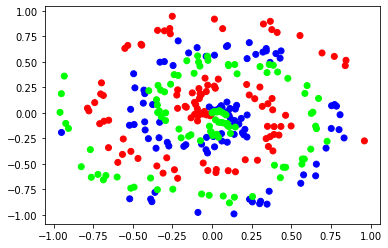

In [ ]:
spiralX, spiralY = datasets.spiral_data(samples=100, classes=3)

plt.scatter(spiralX[:, 0], spiralX[:, 1], c=spiralY, cmap='brg')
plt.show()

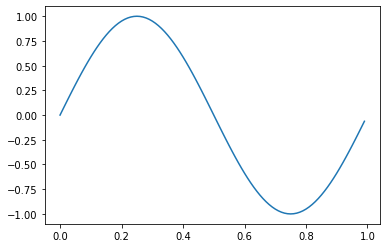

In [ ]:
sineX, sineY = datasets.sine_data(samples=100)

plt.plot(sineX, sineY)

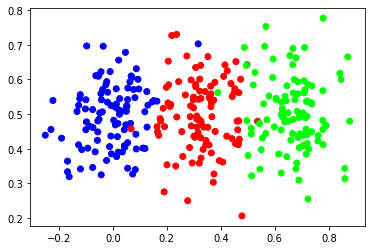

In [ ]:
verticalX, verticalY = datasets.vertical_data(samples=100, classes = 3)

plt.scatter(verticalX[:, 0], verticalX[:, 1], c=verticalY, cmap='brg')
plt.show()

# Testing Optimization Functions

In [ ]:
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)

# Train in loop
for epoch in range(10001):
  # Perform a forward pass of our training data through this layer
  dense1.forward(spiralX)

  # Perform a forward pass through activation function
  # takes the output of first dense layer here
  activation1.forward(dense1.output)

  # Perform a forward pass through second Dense layer
  # takes outputs of activation function of first layer as inputs
  dense2.forward(activation1.output)

  # Perform a forward pass through the activation/loss function
  # takes the output of second dense layer here and returns loss
  loss = loss_activation.forward(dense2.output, spiralY)

  # Calculate accuracy from output of activation2 and targets
  # calculate values along first axis
  predictions = np.argmax(loss_activation.output, axis=1)
  if len(spiralY.shape) == 2:
    spiralY = np.argmax(spiralY, axis=1)
  accuracy = np.mean(predictions==spiralY)

  if not epoch % 1000:

    print(f'epoch: {epoch}, ' +
    f'acc: {accuracy:.3f}, ' +
    f'loss: {loss:.3f}, ' +
    f'lr: {optimizer.current_learning_rate}')

  # Backward pass
  loss_activation.backward(loss_activation.output, spiralY)
  dense2.backward(loss_activation.dinputs)
  activation1.backward(dense2.dinputs)
  dense1.backward(activation1.dinputs)

  # Update weights and biases
  optimizer.pre_update_params()
  optimizer.update_params(dense1)
  optimizer.update_params(dense2)
  optimizer.post_update_params()

epoch: 0, acc: 0.333, loss: 1.099, lr: 0.05
epoch: 1000, acc: 0.827, loss: 0.431, lr: 0.049975037468784345
epoch: 2000, acc: 0.853, loss: 0.380, lr: 0.04995007490013731
epoch: 3000, acc: 0.867, loss: 0.345, lr: 0.049925137256683606
epoch: 4000, acc: 0.870, loss: 0.333, lr: 0.049900224501110035
epoch: 5000, acc: 0.870, loss: 0.313, lr: 0.04987533659617785
epoch: 6000, acc: 0.873, loss: 0.303, lr: 0.04985047350472258
epoch: 7000, acc: 0.890, loss: 0.293, lr: 0.04982563518965381
epoch: 8000, acc: 0.887, loss: 0.287, lr: 0.04980082161395499
epoch: 9000, acc: 0.867, loss: 0.288, lr: 0.04977603274068329
epoch: 10000, acc: 0.887, loss: 0.282, lr: 0.04975126853296942


In [ ]:
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_Step()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_Random()

# Train in loop
for epoch in range(10001):
  # Perform a forward pass of our training data through this layer
  dense1.forward(spiralX)

  # Perform a forward pass through activation function
  # takes the output of first dense layer here
  activation1.forward(dense1.output)

  # Perform a forward pass through second Dense layer
  # takes outputs of activation function of first layer as inputs
  dense2.forward(activation1.output)

  # Perform a forward pass through the activation/loss function
  # takes the output of second dense layer here and returns loss
  loss = loss_activation.forward(dense2.output, spiralY)

  # Calculate accuracy from output of activation2 and targets
  # calculate values along first axis
  predictions = np.argmax(loss_activation.output, axis=1)
  if len(spiralY.shape) == 2:
    spiralY = np.argmax(spiralY, axis=1)
  accuracy = np.mean(predictions==spiralY)

  if not epoch % 1000:

    print(f'epoch: {epoch}, ' +
    f'acc: {accuracy:.3f}, ' +
    f'loss: {loss:.3f}, ')

  # Backward pass
  loss_activation.backward(loss_activation.output, spiralY)
  dense2.backward(loss_activation.dinputs)
  activation1.backward(dense2.dinputs)
  dense1.backward(activation1.dinputs)

  # Update weights and biases
  optimizer.update_params(dense1)
  optimizer.update_params(dense2)
  optimizer.post_update_params()

epoch: 0, acc: 0.310, loss: 1.099, 
epoch: 1000, acc: 0.333, loss: 10.745, 
epoch: 2000, acc: 0.333, loss: 10.742, 
epoch: 3000, acc: 0.333, loss: 10.745, 
epoch: 4000, acc: 0.333, loss: 10.745, 
epoch: 5000, acc: 0.333, loss: 10.745, 
epoch: 6000, acc: 0.333, loss: 10.745, 
epoch: 7000, acc: 0.333, loss: 10.745, 
epoch: 8000, acc: 0.333, loss: 10.745, 
epoch: 9000, acc: 0.333, loss: 10.745, 
epoch: 10000, acc: 0.333, loss: 10.745, 


In [ ]:
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_Step()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_SGD(learning_rate=0.05, decay=5e-7)

# Train in loop
for epoch in range(10001):
  # Perform a forward pass of our training data through this layer
  dense1.forward(verticalX)

  # Perform a forward pass through activation function
  # takes the output of first dense layer here
  activation1.forward(dense1.output)

  # Perform a forward pass through second Dense layer
  # takes outputs of activation function of first layer as inputs
  dense2.forward(activation1.output)

  # Perform a forward pass through the activation/loss function
  # takes the output of second dense layer here and returns loss
  loss = loss_activation.forward(dense2.output, verticalY)

  # Calculate accuracy from output of activation2 and targets
  # calculate values along first axis
  predictions = np.argmax(loss_activation.output, axis=1)
  if len(verticalY.shape) == 2:
    verticalY = np.argmax(verticalY, axis=1)
  accuracy = np.mean(predictions==verticalY)

  if not epoch % 1000:

    print(f'epoch: {epoch}, ' +
    f'acc: {accuracy:.3f}, ' +
    f'loss: {loss:.3f}, ' +
    f'lr: {optimizer.current_learning_rate}')

  # Backward pass
  loss_activation.backward(loss_activation.output, verticalY)
  dense2.backward(loss_activation.dinputs)
  activation1.backward(dense2.dinputs)
  dense1.backward(activation1.dinputs)

  # Update weights and biases
  optimizer.pre_update_params()
  optimizer.update_params(dense1)
  optimizer.update_params(dense2)
  optimizer.post_update_params()

epoch: 0, acc: 0.333, loss: 1.087, lr: 0.05
epoch: 1000, acc: 0.943, loss: 0.165, lr: 0.049975037468784345
epoch: 2000, acc: 0.943, loss: 0.143, lr: 0.04995007490013731
epoch: 3000, acc: 0.950, loss: 0.133, lr: 0.049925137256683606
epoch: 4000, acc: 0.950, loss: 0.127, lr: 0.049900224501110035
epoch: 5000, acc: 0.950, loss: 0.123, lr: 0.04987533659617785
epoch: 6000, acc: 0.950, loss: 0.120, lr: 0.04985047350472258
epoch: 7000, acc: 0.950, loss: 0.117, lr: 0.04982563518965381
epoch: 8000, acc: 0.950, loss: 0.115, lr: 0.04980082161395499
epoch: 9000, acc: 0.950, loss: 0.113, lr: 0.04977603274068329
epoch: 10000, acc: 0.950, loss: 0.112, lr: 0.04975126853296942


In [ ]:
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_Step()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_RMSprop(learning_rate=0.05, decay=5e-7)

# Train in loop
for epoch in range(10001):
  # Perform a forward pass of our training data through this layer
  dense1.forward(verticalX)

  # Perform a forward pass through activation function
  # takes the output of first dense layer here
  activation1.forward(dense1.output)

  # Perform a forward pass through second Dense layer
  # takes outputs of activation function of first layer as inputs
  dense2.forward(activation1.output)

  # Perform a forward pass through the activation/loss function
  # takes the output of second dense layer here and returns loss
  loss = loss_activation.forward(dense2.output, verticalY)

  # Calculate accuracy from output of activation2 and targets
  # calculate values along first axis
  predictions = np.argmax(loss_activation.output, axis=1)
  if len(verticalY.shape) == 2:
    verticalY = np.argmax(verticalY, axis=1)
  accuracy = np.mean(predictions==verticalY)

  if not epoch % 1000:

    print(f'epoch: {epoch}, ' +
    f'acc: {accuracy:.3f}, ' +
    f'loss: {loss:.3f}, ' +
    f'lr: {optimizer.current_learning_rate}')

  # Backward pass
  loss_activation.backward(loss_activation.output, verticalY)
  dense2.backward(loss_activation.dinputs)
  activation1.backward(dense2.dinputs)
  dense1.backward(activation1.dinputs)

  # Update weights and biases
  optimizer.pre_update_params()
  optimizer.update_params(dense1)
  optimizer.update_params(dense2)
  optimizer.post_update_params()

epoch: 0, acc: 0.333, loss: 1.101, lr: 0.05
epoch: 1000, acc: 0.933, loss: 0.191, lr: 0.049975037468784345
epoch: 2000, acc: 0.933, loss: 0.187, lr: 0.04995007490013731
epoch: 3000, acc: 0.933, loss: 0.186, lr: 0.049925137256683606
epoch: 4000, acc: 0.933, loss: 0.185, lr: 0.049900224501110035
epoch: 5000, acc: 0.933, loss: 0.185, lr: 0.04987533659617785
epoch: 6000, acc: 0.933, loss: 0.184, lr: 0.04985047350472258
epoch: 7000, acc: 0.933, loss: 0.184, lr: 0.04982563518965381
epoch: 8000, acc: 0.933, loss: 0.184, lr: 0.04980082161395499
epoch: 9000, acc: 0.933, loss: 0.184, lr: 0.04977603274068329
epoch: 10000, acc: 0.933, loss: 0.184, lr: 0.04975126853296942


In [ ]:
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_Step()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_Adagrad(learning_rate=0.05, decay=5e-7)

# Train in loop
for epoch in range(10001):
  # Perform a forward pass of our training data through this layer
  dense1.forward(verticalX)

  # Perform a forward pass through activation function
  # takes the output of first dense layer here
  activation1.forward(dense1.output)

  # Perform a forward pass through second Dense layer
  # takes outputs of activation function of first layer as inputs
  dense2.forward(activation1.output)

  # Perform a forward pass through the activation/loss function
  # takes the output of second dense layer here and returns loss
  loss = loss_activation.forward(dense2.output, verticalY)

  # Calculate accuracy from output of activation2 and targets
  # calculate values along first axis
  predictions = np.argmax(loss_activation.output, axis=1)
  if len(verticalY.shape) == 2:
    verticalY = np.argmax(verticalY, axis=1)
  accuracy = np.mean(predictions==verticalY)

  if not epoch % 1000:

    print(f'epoch: {epoch}, ' +
    f'acc: {accuracy:.3f}, ' +
    f'loss: {loss:.3f}, ' +
    f'lr: {optimizer.current_learning_rate}')

  # Backward pass
  loss_activation.backward(loss_activation.output, verticalY)
  dense2.backward(loss_activation.dinputs)
  activation1.backward(dense2.dinputs)
  dense1.backward(activation1.dinputs)

  # Update weights and biases
  optimizer.pre_update_params()
  optimizer.update_params(dense1)
  optimizer.update_params(dense2)
  optimizer.post_update_params()

epoch: 0, acc: 0.333, loss: 1.109, lr: 0.05
epoch: 1000, acc: 0.940, loss: 0.166, lr: 0.049975037468784345
epoch: 2000, acc: 0.943, loss: 0.153, lr: 0.04995007490013731
epoch: 3000, acc: 0.950, loss: 0.147, lr: 0.049925137256683606
epoch: 4000, acc: 0.950, loss: 0.144, lr: 0.049900224501110035
epoch: 5000, acc: 0.950, loss: 0.141, lr: 0.04987533659617785
epoch: 6000, acc: 0.953, loss: 0.140, lr: 0.04985047350472258
epoch: 7000, acc: 0.953, loss: 0.138, lr: 0.04982563518965381
epoch: 8000, acc: 0.953, loss: 0.137, lr: 0.04980082161395499
epoch: 9000, acc: 0.953, loss: 0.137, lr: 0.04977603274068329
epoch: 10000, acc: 0.953, loss: 0.136, lr: 0.04975126853296942


In [ ]:
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(1, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_Linear()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 1)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_Adagrad(learning_rate=0.05, decay=5e-7)

# Train in loop
for epoch in range(10001):
  # Perform a forward pass of our training data through this layer
  dense1.forward(sineX)

  # Perform a forward pass through activation function
  # takes the output of first dense layer here
  activation1.forward(dense1.output)

  # Perform a forward pass through second Dense layer
  # takes outputs of activation function of first layer as inputs
  dense2.forward(activation1.output)

  # Perform a forward pass through the activation/loss function
  # takes the output of second dense layer here and returns loss
  loss = loss_activation.forward(dense2.output, sineY)

  # Calculate accuracy from output of activation2 and targets
  # calculate values along first axis
  predictions = np.argmax(loss_activation.output, axis=1)
  if len(sineY.shape) == 2:
    sineY = np.argmax(sineY, axis=1)
  accuracy = np.mean(predictions==sineY)

  if not epoch % 1000:

    print(f'epoch: {epoch}, ' +
    f'acc: {accuracy:.3f}, ' +
    f'loss: {loss:.3f}, ' +
    f'lr: {optimizer.current_learning_rate}')

  # Backward pass
  loss_activation.backward(loss_activation.output, sineY)
  dense2.backward(loss_activation.dinputs)
  activation1.backward(dense2.dinputs)
  dense1.backward(activation1.dinputs)

  # Update weights and biases
  optimizer.pre_update_params()
  optimizer.update_params(dense1)
  optimizer.update_params(dense2)
  optimizer.post_update_params()

epoch: 0, acc: 1.000, loss: nan, lr: 0.05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log


epoch: 1000, acc: 1.000, loss: 0.000, lr: 0.049975037468784345
epoch: 2000, acc: 1.000, loss: 0.000, lr: 0.04995007490013731
epoch: 3000, acc: 1.000, loss: 0.000, lr: 0.049925137256683606
epoch: 4000, acc: 1.000, loss: 0.000, lr: 0.049900224501110035
epoch: 5000, acc: 1.000, loss: 0.000, lr: 0.04987533659617785
epoch: 6000, acc: 1.000, loss: 0.000, lr: 0.04985047350472258
epoch: 7000, acc: 1.000, loss: 0.000, lr: 0.04982563518965381
epoch: 8000, acc: 1.000, loss: 0.000, lr: 0.04980082161395499
epoch: 9000, acc: 1.000, loss: 0.000, lr: 0.04977603274068329
epoch: 10000, acc: 1.000, loss: 0.000, lr: 0.04975126853296942


In [ ]:
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(1, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 1)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_Adagrad(learning_rate=0.05, decay=5e-7)

# Train in loop
for epoch in range(10001):
  # Perform a forward pass of our training data through this layer
  dense1.forward(sineX)

  # Perform a forward pass through activation function
  # takes the output of first dense layer here
  activation1.forward(dense1.output)

  # Perform a forward pass through second Dense layer
  # takes outputs of activation function of first layer as inputs
  dense2.forward(activation1.output)

  # Perform a forward pass through the activation/loss function
  # takes the output of second dense layer here and returns loss
  loss = loss_activation.forward(dense2.output, sineY)

  # Calculate accuracy from output of activation2 and targets
  # calculate values along first axis
  predictions = np.argmax(loss_activation.output, axis=1)
  if len(sineY.shape) == 2:
    sineY = np.argmax(sineY, axis=1)
  accuracy = np.mean(predictions==sineY)

  if not epoch % 1000:

    print(f'epoch: {epoch}, ' +
    f'acc: {accuracy:.3f}, ' +
    f'loss: {loss:.3f}, ' +
    f'lr: {optimizer.current_learning_rate}')

  # Backward pass
  loss_activation.backward(loss_activation.output, sineY)
  dense2.backward(loss_activation.dinputs)
  activation1.backward(dense2.dinputs)
  dense1.backward(activation1.dinputs)

  # Update weights and biases
  optimizer.pre_update_params()
  optimizer.update_params(dense1)
  optimizer.update_params(dense2)
  optimizer.post_update_params()

epoch: 0, acc: 1.000, loss: 0.000, lr: 0.05
epoch: 1000, acc: 1.000, loss: 0.000, lr: 0.049975037468784345
epoch: 2000, acc: 1.000, loss: 0.000, lr: 0.04995007490013731
epoch: 3000, acc: 1.000, loss: 0.000, lr: 0.049925137256683606
epoch: 4000, acc: 1.000, loss: 0.000, lr: 0.049900224501110035
epoch: 5000, acc: 1.000, loss: 0.000, lr: 0.04987533659617785
epoch: 6000, acc: 1.000, loss: 0.000, lr: 0.04985047350472258
epoch: 7000, acc: 1.000, loss: 0.000, lr: 0.04982563518965381
epoch: 8000, acc: 1.000, loss: 0.000, lr: 0.04980082161395499
epoch: 9000, acc: 1.000, loss: 0.000, lr: 0.04977603274068329
epoch: 10000, acc: 1.000, loss: 0.000, lr: 0.04975126853296942


In [ ]:
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(1, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_Linear()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 1)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_Adagrad(learning_rate=0.05, decay=5e-7)

# Train in loop
for epoch in range(10001):
  # Perform a forward pass of our training data through this layer
  dense1.forward(sineX)

  # Perform a forward pass through activation function
  # takes the output of first dense layer here
  activation1.forward(dense1.output)

  # Perform a forward pass through second Dense layer
  # takes outputs of activation function of first layer as inputs
  dense2.forward(activation1.output)

  # Perform a forward pass through the activation/loss function
  # takes the output of second dense layer here and returns loss
  loss = loss_activation.forward(dense2.output, sineY)

  # Calculate accuracy from output of activation2 and targets
  # calculate values along first axis
  predictions = np.argmax(loss_activation.output, axis=1)
  if len(sineY.shape) == 2:
    sineY = np.argmax(sineY, axis=1)
  accuracy = np.mean(predictions==sineY)

  if not epoch % 1000:

    print(f'epoch: {epoch}, ' +
    f'acc: {accuracy:.3f}, ' +
    f'loss: {loss:.3f}, ' +
    f'lr: {optimizer.current_learning_rate}')

  # Backward pass
  loss_activation.backward(loss_activation.output, sineY)
  dense2.backward(loss_activation.dinputs)
  activation1.backward(dense2.dinputs)
  dense1.backward(activation1.dinputs)

  # Update weights and biases
  optimizer.pre_update_params()
  optimizer.update_params(dense1)
  optimizer.update_params(dense2)
  optimizer.post_update_params()

epoch: 0, acc: 1.000, loss: 0.000, lr: 0.05
epoch: 1000, acc: 1.000, loss: 0.000, lr: 0.049975037468784345
epoch: 2000, acc: 1.000, loss: 0.000, lr: 0.04995007490013731
epoch: 3000, acc: 1.000, loss: 0.000, lr: 0.049925137256683606
epoch: 4000, acc: 1.000, loss: 0.000, lr: 0.049900224501110035
epoch: 5000, acc: 1.000, loss: 0.000, lr: 0.04987533659617785
epoch: 6000, acc: 1.000, loss: 0.000, lr: 0.04985047350472258
epoch: 7000, acc: 1.000, loss: 0.000, lr: 0.04982563518965381
epoch: 8000, acc: 1.000, loss: 0.000, lr: 0.04980082161395499
epoch: 9000, acc: 1.000, loss: 0.000, lr: 0.04977603274068329
epoch: 10000, acc: 1.000, loss: 0.000, lr: 0.04975126853296942


# Prediction of Data

In [ ]:
trainX, trainY = datasets.vertical_data(samples=200, classes=3)
testX, testY = datasets.vertical_data(samples=50, classes=3)

In [ ]:
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

activation2 = Activation_Softmax()

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_SGD(learning_rate=0.05, decay=5e-7)

# Train in loop
for epoch in range(10001):
  # Perform a forward pass of our training data through this layer
  dense1.forward(trainX)

  # Perform a forward pass through activation function
  # takes the output of first dense layer here
  activation1.forward(dense1.output)

  # Perform a forward pass through second Dense layer
  # takes outputs of activation function of first layer as inputs
  dense2.forward(activation1.output)

  # Perform a forward pass through the activation/loss function
  # takes the output of second dense layer here and returns loss
  loss = loss_activation.forward(dense2.output, trainY)

  # Calculate accuracy from output of activation2 and targets
  # calculate values along first axis
  predictions = np.argmax(loss_activation.output, axis=1)
  if len(trainY.shape) == 2:
    trainY = np.argmax(spiralY, axis=1)
  accuracy = np.mean(predictions==trainY)

  if not epoch % 1000:

    print(f'epoch: {epoch}, ' +
    f'acc: {accuracy:.3f}, ' +
    f'loss: {loss:.3f}, ' +
    f'lr: {optimizer.current_learning_rate}')

  # Backward pass
  loss_activation.backward(loss_activation.output, trainY)
  dense2.backward(loss_activation.dinputs)
  activation1.backward(dense2.dinputs)
  dense1.backward(activation1.dinputs)

  # Update weights and biases
  optimizer.pre_update_params()
  optimizer.update_params(dense1)
  optimizer.update_params(dense2)
  optimizer.post_update_params()

epoch: 0, acc: 0.333, loss: 1.099, lr: 0.05
epoch: 1000, acc: 0.948, loss: 0.331, lr: 0.049975037468784345
epoch: 2000, acc: 0.947, loss: 0.170, lr: 0.04995007490013731
epoch: 3000, acc: 0.947, loss: 0.146, lr: 0.049925137256683606
epoch: 4000, acc: 0.947, loss: 0.138, lr: 0.049900224501110035
epoch: 5000, acc: 0.948, loss: 0.135, lr: 0.04987533659617785
epoch: 6000, acc: 0.948, loss: 0.134, lr: 0.04985047350472258
epoch: 7000, acc: 0.948, loss: 0.133, lr: 0.04982563518965381
epoch: 8000, acc: 0.948, loss: 0.132, lr: 0.04980082161395499
epoch: 9000, acc: 0.948, loss: 0.132, lr: 0.04977603274068329
epoch: 10000, acc: 0.948, loss: 0.132, lr: 0.04975126853296942


In [ ]:
# Perform a forward pass of our training data through this layer
dense1.forward(testX)

# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)

# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)

# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense2.output, testY)

# Calculate accuracy from output of activation2 and targets
# calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(trainY.shape) == 2:
  testY = np.argmax(testY, axis=1)
accuracy = np.mean(predictions==testY)

accuracy

0.9

In [ ]:
class test:

  def predict(self, testX):

    dense1.forward(testX)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    return np.argmax(activation2.output, axis=1)    

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


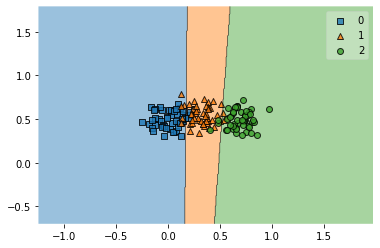

In [ ]:
from mlxtend.plotting import plot_decision_regions

neuron = test()

neuron.predict(testX)
plot_decision_regions(testX, testY, clf=neuron)